(scrna_seq_workflow)=

## Scarf's basic workflow for scRNA-Seq

This workflow is meant to familiarize users with the Scarf API and how data is internally handled in Scarf. Please checkout the quick start guide if you are interested in the minimal steps required to run the analysis.

In [1]:
%load_ext autotime

import scarf
scarf.__version__

C:\Users\parashar\miniconda3\envs\scarf_web\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\parashar\miniconda3\envs\scarf_web\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\parashar\miniconda3\envs\scarf_web\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\parashar\miniconda3\envs\scarf_web\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


'0.24.0'

time: 12.5 s (started: 2022-10-19 15:56:57 +02:00)


In [2]:
import session_info

session_info.show(dependencies=True, os=True, html=False)

ModuleNotFoundError: No module named 'session_info'

time: 1.12 s (started: 2022-10-19 15:57:09 +02:00)


Download the count matrix from 10x's website using the `fetch_dataset` function. This is a convenience function that stores URLs of datasets that can be downloaded. The `save_path` parameter allows the data to be saved to a location of choice.

In [2]:
scarf.fetch_dataset(
    'tenx_5K_pbmc_rnaseq',
    save_path='scarf_datasets'
)

time: 10.2 s (started: 2021-09-06 20:49:06 +02:00)


---
### 1) Format conversion

The first step of the analysis workflow is to convert the file into the Zarr format that is supported by Scarf. We read in the data using `CrH5Reader` (stands for cellranger H5 reader). The reader object allows quick investigation of the file before the format is converted.

In [2]:
reader = scarf.CrH5Reader('scarf_datasets/tenx_5K_pbmc_rnaseq/data.h5')

time: 47 ms (started: 2021-09-28 21:36:29 +02:00)


We can quickly check the number of cells and features (genes as well as ADT features in this case) present in the file.

In [4]:
reader.nCells, reader.nFeatures

(5025, 33538)

time: 0 ns (started: 2021-09-06 20:49:16 +02:00)


Next we convert the data to the Zarr format that will later on be used by Scarf. For this we use Scarf's `CrToZarr` class. This class will first quickly ascertain the type of data to be written and then create a Zarr format file for the data to be written into. `CrToZarr` takes two mandatory arguments. The first is the cellranger reader, and the other is the name of the output file.

<div class="alert alert-block alert-info">
NOTE: When we say zarr file, we actually mean zarr directory  because, unlike HDF5, Zarr hierarchy is organized as a directory structure.
</div>

In [5]:
writer = scarf.CrToZarr(
    reader,
    zarr_fn='scarf_datasets/tenx_5K_pbmc_rnaseq/data.zarr',
    chunk_size=(2000, 1000)
)
writer.dump(batch_size=1000)

  0%|                                                                                                         …

time: 5.23 s (started: 2021-09-06 20:49:16 +02:00)


The next step is to create a Scarf `DataStore` object. This object will be the primary way to interact with the data and all its constituent assays. When a Zarr file is loaded, Scarf checks if some per-cell statistics have been calculated. If not, then **nFeatures** (number of features per cell) and **nCounts** (total sum of feature counts per cell) are calculated. Scarf will also attempt to calculate the percent of mitochondrial and ribosomal content per cell. When we create a DataStore instance, we can decide to filter out low abundance genes with parameter `min_features_per_cell`. For example the value of 10 for `min_features_per_cell` below means that those genes that are present in less than 10 cells will be filtered out.

In [1]:
import scarf
import anndata

In [3]:
ds = scarf.DataStore(
    'scarf_datasets/tenx_5K_pbmc_rnaseq/data.zarr',
    nthreads=4,
    min_features_per_cell=10
)
ds

DataStore has 3940 (5025) cells with 1 assays: RNA
   Cell metadata:
            'I', 'ids', 'names', 'RNA_UMAP1', 'RNA_UMAP2', 
            'RNA_cluster', 'RNA_leiden_cluster', 'RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito', 
            'RNA_percentRibo'
   RNA assay has 13632 (33538) features and following metadata:
            'I', 'ids', 'names', 'I__hvgs', 'dropOuts', 
            'nCells'

time: 140 ms (started: 2022-10-19 15:57:12 +02:00)


In [3]:
scarf.writers.to_h5ad(ds.RNA, 'scarf_datasets/tenx_5K_pbmc_rnaseq/dataout.h5ad')

Writing raw counts:   0%|                                                                                     …

In [4]:
adata = anndata.read_h5ad('scarf_datasets/tenx_5K_pbmc_rnaseq/dataout.h5ad')
adata

AnnData object with n_obs × n_vars = 5025 × 33538
    obs: 'I', '_index', 'names', 'RNA_cluster', 'RNA_leiden_cluster', 'RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito', 'RNA_percentRibo'
    var: 'I', '_index', 'gene_short_name', 'I__hvgs', 'dropOuts', 'nCells'
    obsm: 'X_umap'

In [6]:
ds.to_anndata()

INFO: Converting raw data from RNA assay into CSR format:   0%|                                               …

C:\Users\parashar\miniconda3\envs\scarf\lib\site-packages\scarf\datastore.py:4345: FutureWarning: X.dtype being converted to np.float32 from uint32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(assay.to_raw_sparse(cell_key), obs=obs, var=var)


AnnData object with n_obs × n_vars = 3940 × 33538
    obs: 'I', 'names', 'RNA_UMAP1', 'RNA_UMAP2', 'RNA_cluster', 'RNA_leiden_cluster', 'RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito', 'RNA_percentRibo'
    var: 'I', 'names', 'I__hvgs', 'dropOuts', 'nCells'

In [4]:
metadata = {
    'dataset1': {
        'species': 'sapiens',
        'treament': 'control',
        'goofy_info': 'whatever',
    },
    'dataset2': {
        'species': 'sapiens',
        'treament': 'treatment',
    },
    'dataset3': {
        'species': 'sapiens',
    },
    'dataset4': {
        'species': 'sapiens',
        'treament': 'chemo',
    }
}

time: 0 ns (started: 2022-10-12 14:54:30 +02:00)


In [5]:
metadata

{'dataset1': {'species': 'sapiens',
  'treament': 'control',
  'goofy_info': 'whatever'},
 'dataset2': {'species': 'sapiens', 'treament': 'treatment'},
 'dataset3': {'species': 'sapiens'},
 'dataset4': {'species': 'sapiens', 'treament': 'chemo'}}

time: 16 ms (started: 2022-10-12 14:54:38 +02:00)


In [18]:
all_keys = []
for i in metadata:
    for j in metadata[i]:
        all_keys.append(j)
all_keys = set(all_keys)
all_keys

{'goofy_info', 'species', 'treament'}

time: 0 ns (started: 2022-10-12 15:02:55 +02:00)


In [28]:
ds

DataStore has 3940 (5025) cells with 1 assays: RNA
   Cell metadata:
            'I', 'ids', 'names', 'RNA_UMAP1', 'RNA_UMAP2', 
            'RNA_cluster', 'RNA_leiden_cluster', 'RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito', 
            'RNA_percentRibo'
   RNA assay has 13632 (33538) features and following metadata:
            'I', 'ids', 'names', 'I__hvgs', 'dropOuts', 
            'nCells'

time: 32 ms (started: 2022-10-12 15:06:36 +02:00)


In [19]:
merged_ds.cells.insert(
    column_name='sample_id',
    values=[x.split('__')[0] for x in merged_ds.cells.fetch_all('ids')],
    overwrite=True
)

time: 78 ms (started: 2022-10-12 15:04:29 +02:00)


In [32]:
for i in all_keys:
    data = [metadata[x][i] if i in metadata[x] else -1 for x in merged_ds.cells.fetch('sample_id')]
    merged_ds.cells.insert(
        column_name=i,
        values=data,
        overwrite=True
    )

time: 219 ms (started: 2022-10-12 15:08:57 +02:00)


In [33]:
merged_ds.cells.columns

['I',
 'ids',
 'names',
 'RNA_nCounts',
 'RNA_nFeatures',
 'RNA_percentMito',
 'RNA_percentRibo',
 'goofy_info',
 'orig_RNA_UMAP1',
 'orig_RNA_UMAP2',
 'orig_RNA_cluster',
 'orig_RNA_leiden_cluster',
 'orig_RNA_nCounts',
 'orig_RNA_nFeatures',
 'orig_RNA_percentMito',
 'orig_RNA_percentRibo',
 'sample_id',
 'species',
 'treament']

time: 0 ns (started: 2022-10-12 15:09:02 +02:00)


control      5025
treatment    5025
-1           5025
chemo        5025
dtype: int64

time: 46 ms (started: 2022-10-12 15:07:12 +02:00)


In [9]:
writer = scarf.ZarrMerge(
    'testing_merge.zarr',
    merge_assay_name='RNA',
    assays=[ds.RNA, ds.RNA, ds.RNA, ds.RNA],
    names= ['dataset1', 'dataset2', 'dataset3', 'dataset4']
)
writer.dump()

Writing data to merged file:   0%|                                                                            …

Writing data to merged file:   0%|                                                                            …

Writing data to merged file:   0%|                                                                            …

Writing data to merged file:   0%|                                                                            …

time: 54.7 s (started: 2022-10-12 14:56:14 +02:00)


In [10]:
merged_ds = scarf.DataStore('testing_merge.zarr')

(RNA) Computing nCells and dropOuts:   0%|                                                                    …

(RNA) Computing nCounts:   0%|                                                                                …

(RNA) Computing nFeatures:   0%|                                                                              …

(RNA) Computing RNA_percentMito:   0%|                                                                        …

(RNA) Computing RNA_percentRibo:   0%|                                                                        …

time: 28 s (started: 2022-10-12 14:59:49 +02:00)


In [17]:
merged_ds.cells.columns

['I',
 'ids',
 'names',
 'RNA_nCounts',
 'RNA_nFeatures',
 'RNA_percentMito',
 'RNA_percentRibo',
 'orig_RNA_UMAP1',
 'orig_RNA_UMAP2',
 'orig_RNA_cluster',
 'orig_RNA_leiden_cluster',
 'orig_RNA_nCounts',
 'orig_RNA_nFeatures',
 'orig_RNA_percentMito',
 'orig_RNA_percentRibo']

time: 0 ns (started: 2022-10-12 15:01:29 +02:00)


In [16]:
merged_ds.cells.to_pandas_dataframe(columns=merged_ds.cells.columns)

,I,ids,names,RNA_nCounts,RNA_nFeatures,RNA_percentMito,RNA_percentRibo,orig_RNA_UMAP1,orig_RNA_UMAP2,orig_RNA_cluster,orig_RNA_leiden_cluster,orig_RNA_nCounts,orig_RNA_nFeatures,orig_RNA_percentMito,orig_RNA_percentRibo
0,True,dataset1__AAACCCAAGCGTATGG-1,AAACCCAAGCGTATGG-1,13537.0,3503.0,10.844353,16.783630,7.293923,14.100091,1,2,13537.0,3503.0,10.844353,16.783630
1,True,dataset1__AAACCCAGTCCTACAA-1,AAACCCAGTCCTACAA-1,12668.0,3381.0,5.975687,20.034733,18.425434,23.808584,1,2,12668.0,3381.0,5.975687,20.034733
2,True,dataset1__AAACCCATCACCTCAC-1,AAACCCATCACCTCAC-1,962.0,346.0,53.430353,2.494802,NaN,NaN,-1,-1,962.0,346.0,53.430353,2.494802
3,True,dataset1__AAACGCTAGGGCATGT-1,AAACGCTAGGGCATGT-1,5788.0,1799.0,10.919143,28.783690,-15.075859,28.809582,8,7,5788.0,1799.0,10.919143,28.783690
4,True,dataset1__AAACGCTGTAGGTACG-1,AAACGCTGTAGGTACG-1,13186.0,2887.0,7.955407,35.750038,-12.008954,8.613762,4,1,13186.0,2887.0,7.955407,35.750038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20095,True,dataset4__TTTGTTGCAGGTACGA-1,TTTGTTGCAGGTACGA-1,8150.0,1992.0,7.263804,40.380368,-7.219402,10.835420,2,1,8150.0,1992.0,7.263804,40.380368
20096,True,dataset4__TTTGTTGCAGTCTCTC-1,TTTGTTGCAGTCTCTC-1,9625.0,2485.0,5.693506,35.740260,-0.849334,-17.375633,5,3,9625.0,2485.0,5.693506,35.740260
20097,True,dataset4__TTTGTTGGTAATTAGG-1,TTTGTTGGTAATTAGG-1,2637.0,882.0,18.543800,15.889268,NaN,NaN,-1,-1,2637.0,882.0,18.543800,15.889268
20098,True,dataset4__TTTGTTGTCCTTGGAA-1,TTTGTTGTCCTTGGAA-1,5527.0,2006.0,8.178035,25.348290,-19.229261,21.307312,7,6,5527.0,2006.0,8.178035,25.348290


time: 172 ms (started: 2022-10-12 15:01:24 +02:00)


In [3]:
ds

DataStore has 3940 (5025) cells with 1 assays: RNA
   Cell metadata:
            'I', 'ids', 'names', 'RNA_UMAP1', 'RNA_UMAP2', 
            'RNA_cluster', 'RNA_leiden_cluster', 'RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito', 
            'RNA_percentRibo'
   RNA assay has 13632 (33538) features and following metadata:
            'I', 'ids', 'names', 'I__hvgs', 'dropOuts', 
            'nCells'

time: 47 ms (started: 2022-10-12 14:51:53 +02:00)


In [5]:
adata = adata[adata.obs.I]

In [ ]:
import numpy as np

In [8]:
data = np.array([ds.RNA.cells.fetch_all(x) for x in ['RNA_UMAP1', 'RNA_UMAP2']])

In [10]:
data.shape

(2, 5025)

In [11]:
data.dtype

dtype('float32')

In [13]:
data.T

array([[  7.293923,  14.100091],
       [ 18.425434,  23.808584],
       [       nan,        nan],
       ...,
       [       nan,        nan],
       [-19.229261,  21.307312],
       [ -8.562345, -15.087895]], dtype=float32)

In [ ]:
adata = anndata.read_h5ad( 'scarf_datasets/tenx_5K_pbmc_rnaseq/dataout.h5ad')

In [ ]:
adata

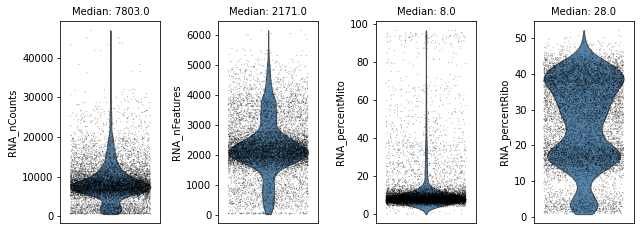

time: 562 ms (started: 2022-08-15 01:39:25 +02:00)


In [10]:
ds.plot_cells_dists()

---
### 2) Cell filtering

We can visualize the per-cell statistics in [violin plots](https://datavizcatalogue.com/methods/violin_plot.html) before we start filtering cells out.

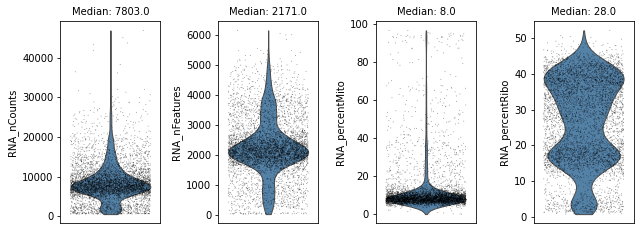

time: 1.22 s (started: 2021-09-06 20:49:24 +02:00)


In [7]:
ds.plot_cells_dists()

We can filter cells based on these cell attributes by providing upper and lower threshold values.

In [8]:
ds.filter_cells(
    attrs=['RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito'],
    highs=[15000, 4000, 15],
    lows=[1000, 500, 0]
)

INFO: 597 cells flagged for filtering out using attribute RNA_nCounts
INFO: 461 cells flagged for filtering out using attribute RNA_nFeatures
INFO: 612 cells flagged for filtering out using attribute RNA_percentMito
time: 16 ms (started: 2021-09-06 20:49:25 +02:00)


Now we visualize the attributes again after filtering the values. 

*Note: the 'I' value given as the `cell_key` attribute signifies the column of the table that is set to `False` for cells that were filtered out or `True` for cells that are kept.*


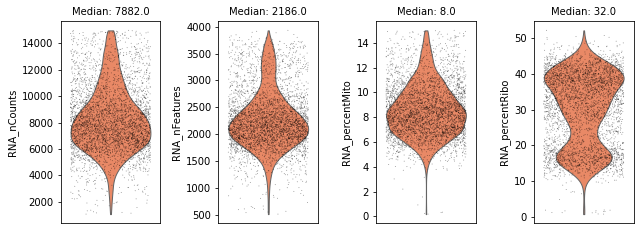

time: 375 ms (started: 2021-09-06 20:49:25 +02:00)


In [9]:
ds.plot_cells_dists(cell_key='I', color='coral')

The data stored under the 'cellData' level can easily be accessed using the `cells` attribute of the `DataStore` object.

In [ ]:
ds.cells.head()

<div class="alert alert-block alert-info">
NOTE: We strongly discourage directly adding or removing the data from this table as Scarf will not be able to synchronize the changes to the disk. Instead use the methods of the <code>cells</code> attribute. Please refer to the <code>insert</code>, <code>fetch</code>, <code>fetch_all</code>, <code>drop</code> and <code>update_key</code> methods.
</div>

---
### 3) Feature selection

Similar to the cell table, Scarf also saves the feature level data that can be accessed as below:

In [ ]:
ds.RNA.feats.head()

The feature selection step is performed on the normalized data. The default normalization method for `RNAassay`-type data is library-size normalization, wherein the count values are divided by the sum of total values for a cell. These values are then multiplied by a scalar factor. The default value of this scalar factor is 1000. However, if the total counts in a cell are less than this value, then on multiplication with this scalar factor the values will be 'scaled up' (which is not a desired behaviour). In the filtering step above, we set the `low` threshold for `RNA_nCounts` at 1000, and hence it is safe to use 1000 as a scalar factor. The scalar factor can be set by modifying the `sf` attribute of the assay. Let's print the default value of `sf`

In [ ]:
ds.RNA.sf

Now the next step is to identify the highly variable genes in the dataset (for the RNA assay). This can be done using the `mark_hvgs` method of the assay. The parameters govern the min/max variance (corrected) and mean expression threshold for calling genes highly variable. 

The variance is corrected by first dividing genes into bins based on their mean expression values. Genes with minimum variance is selected from each bin and a Lowess curve is fitted to the mean-variance trend of these genes. `mark_hvgs` will by default run on the default assay.

A plot is produced, that for each gene shows the corrected variance on the y-axis and the non-zero mean (means from cells where the gene had a non-zero value) on the x-axis. The genes are colored in two gradients which indicate the number of cells where the gene was expressed. The colors are yellow to dark red for HVGs, and blue to green for non-HVGs.

The `mark_hvgs` function has a parameter `cell_key` that dictates which cells to use to identify the HVGs. The default value of this parameter is `I`, which means it will use all the cells that were not filtered out.

In [ ]:
ds.mark_hvgs(
    min_cells=20,
    top_n=500,
    min_mean=-3,
    max_mean=2,
    max_var=6
)

As a result of running `mark_hvgs`, the feature table now has an extra column **I\_\_hvgs** which contains a `True` value for genes marked HVGs. The naming rule in Scarf dictates that cells used to identify HVGs are prepended to the column name (with a double underscore delimiter). Since we did not provide any `cell_key` parameter the default value was used, i.e. the filtered cells. This resulted in **I** becoming the prefix.

In [ ]:
ds.RNA.feats.head()

### 4) Graph creation

Creating a neighbourhood graph of cells is the most critical step in any Scarf workflow. This step internally involves multiple substeps: 

- data normalization for selected features
- linear dimensionality reduction using PCA
- creating an approximate nearest neighbour graph index (using the HNSWlib library)
- querying cells against this index to identify nearest neighbours for each cell
- edge weight computation using the `compute_membership_strengths` function from the UMAP package
- fitting MiniBatch Kmeans (The kmeans centers are used later, for UMAP initialization)

The `make_graph` method is responsible for graph construction. Its method takes a mandatory parameter: `feat_key`. This should be a column in the feature metadata table that indicates which genes to use to create the graph. Since we have already identified the `hvgs` in the step above, we use those genes. Note that we do not need to write *I\_\_hvgs* but just *hvgs* as the value of the parameter. We also supply values for two very important parameters here: `k` (number of nearest neighbours to be queried for each cell) and `dims` (number of PCA dimensions to use for graph construction). `n_centroids` parameter controls number of clusters to create for the data using the Kmeans algorithm. We perform a more accurate clustering of data in the later steps.

In [ ]:
ds.make_graph(
    feat_key='hvgs',
    k=11,
    dims=15,
    n_centroids=100
)

---
### 5) Low dimensional embedding and clustering

Next we run UMAP on the graph calculated above. Here we will not provide which cell key or feature key to be used, because we want the UMAP to run on all the cells that were not filtered out and with the feature key used to calculate the latest graph. We can provide the parameter values for the UMAP algorithm here.

In [ ]:
ds.run_umap(
    n_epochs=250,
    spread=5,
    min_dist=1,
    parallel=True
)

The UMAP results are saved in the cell metadata table as seen below in columns: **RNA_UMAP1** and **RNA_UMAP2**

In [ ]:
ds.cells.head()

`plot_layout` is a versatile method to create a [scatter plot](https://datavizcatalogue.com/methods/scatterplot.html) using Scarf. Here we can plot the UMAP coordinates of all the non-filtered out cells.

In [ ]:
ds.plot_layout(layout_key='RNA_UMAP')

`plot_layout` can be used to easily visualize data from any column of the cell metadata table. Next, we visualize the number of genes expressed in each cell.

In [ ]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_nCounts',
    cmap='coolwarm'
)

There has been a lot of discussion over the choice of non-linear dimensionality reduction for single-cell data. tSNE was initially considered an excellent solution, but has gradually lost out to UMAP because the magnitude of relations between the clusters cannot easily be discerned in a tSNE plot. Scarf contains an implementation of tSNE that runs directly on the graph structure of cells. So, essentially the same data that was used to create the UMAP and clustering is used.

In [ ]:
ds.run_tsne(
    alpha=10,
    box_h=1,
    early_iter=250,
    max_iter=500,
    parallel=True
)

<div class="alert alert-block alert-info">
NOTE: The tSNE implementation is currently not supported on Windows.
</div>

In [ ]:
# Here we run plot_layout under exception catching because if you are not on Linux then the `run_tnse` would have failed.
try:
    ds.plot_layout(layout_key='RNA_tSNE')
except KeyError:
    print ("'RNA_tSNE1' not found in MetaData")

---
### 6) Cell clustering

Identifying clusters of cells is one of the central tenets of single cell approaches. Scarf includes two graph clustering methods and any (or even both) can be used on the dataset. The methods start with the same graph as the UMAP algorithm above to minimize the disparity between the UMAP and clustering results. The two clustering methods are:

- **Paris**: This is the default clustering algorithm.
- **Leiden**: Leiden is a widely used graph clustering algorithm in single-cell genomics.

Paris is the default algorithm in Scarf due to its ability to highlight cluster relationships. [Paris](https://github.com/tbonald/paris) is a hierarchical graph clustering algorithm that is based on node pair sampling. Paris creates a dendrogram of cells which can then be cut to obtain desired number of clusters. The advantage of using Paris, especially in the larger datasets, is that once the dendrogram has been created one can change the desired number of clusters with minimal computation overhead.

In [22]:
# We start with Leiden clustering
ds.run_leiden_clustering(resolution=0.5)

time: 156 ms (started: 2021-09-06 20:49:41 +02:00)


We can visualize the results using the `plot_layout` method again. Here we plot both UMAP and colour cells based on their cluster identity, as obtained using Leiden clustering.

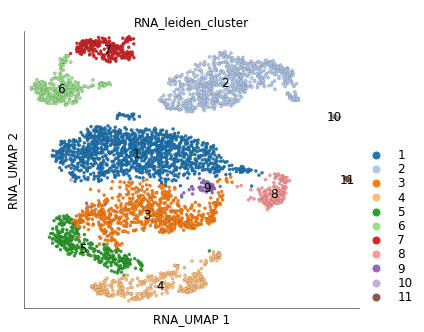

time: 407 ms (started: 2021-09-06 20:49:41 +02:00)


In [23]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_leiden_cluster'
)

The results of the clustering algorithm are saved in the cell metadata table. In this case, they have been saved under the column name **RNA_leiden_cluster**.

In [24]:
ds.cells.head()

,I,ids,names,RNA_UMAP1,RNA_UMAP2,RNA_leiden_cluster,RNA_nCounts,RNA_nFeatures,RNA_percentMito,RNA_percentRibo
0,True,AAACCCAAGCGTATGG-1,AAACCCAAGCGTATGG-1,7.293923,14.100091,2,13537.0,3503.0,10.844353,16.783630
1,True,AAACCCAGTCCTACAA-1,AAACCCAGTCCTACAA-1,18.425434,23.808584,2,12668.0,3381.0,5.975687,20.034733
2,False,AAACCCATCACCTCAC-1,AAACCCATCACCTCAC-1,NaN,NaN,-1,962.0,346.0,53.430353,2.494802
3,True,AAACGCTAGGGCATGT-1,AAACGCTAGGGCATGT-1,-15.075859,28.809582,7,5788.0,1799.0,10.919143,28.783690
4,True,AAACGCTGTAGGTACG-1,AAACGCTGTAGGTACG-1,-12.008954,8.613762,1,13186.0,2887.0,7.955407,35.750038


time: 31 ms (started: 2021-09-06 20:49:41 +02:00)


We can export the Leiden cluster information into a pandas dataframe. Setting `key` to `I` makes sure that we do not include the data for cells that were filtered out.

In [25]:
leiden_clusters = ds.cells.to_pandas_dataframe(
    columns=['RNA_leiden_cluster'],
    key='I'
)
leiden_clusters.head()

,RNA_leiden_cluster
0,2
1,2
3,7
4,1
6,4


time: 15 ms (started: 2021-09-06 20:49:41 +02:00)


Now we run Paris clustering algorithm using `run_clustering` method. Paris clustering requires only one parameter: `n_clusters`, which determines the number of clusters to create. Here we set the number of clusters same as that were obtained using Leiden clustering.leiden_clusters.nunique()

In [26]:
ds.run_clustering(n_clusters=leiden_clusters.nunique()[0])

time: 500 ms (started: 2021-09-06 20:49:41 +02:00)


Visualizing Paris clusters

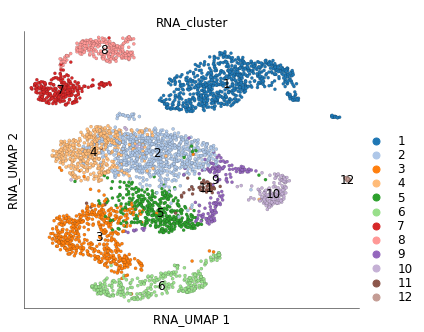

time: 312 ms (started: 2021-09-06 20:49:42 +02:00)


In [27]:
ds.plot_layout(
    layout_key='RNA_UMAP',
    color_by='RNA_cluster'
)

Discerning similarity between clusters can be difficult from visual inspection alone, especially for tSNE plots. `plot_cluster_tree` function plots the relationship between clusters as a binary tree. This tree is simply a condensation of the dendrogram obtained using Paris clustering.

Constructing graph from dendrogram:   0%|                                                                     …

Identifying the top node for cluster:   0%|                                                                   …

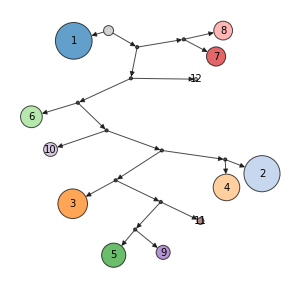

time: 532 ms (started: 2021-09-06 20:49:42 +02:00)


In [28]:
ds.plot_cluster_tree(cluster_key='RNA_cluster', width=1)

The tree is free form (i.e the position of clusters doesn't convey any meaning) but allows inspection of cluster similarity based on branching pattern. The sizes of clusters indicate the number of cells present in each cluster. The tree starts from the root node (black dot with no incoming edges). 

---
### 7) Marker gene identification

Now we can identify the genes that are differentially expressed between the clusters using the `run_marker_search` method. The method to identify the differentially expressed genes in Scarf is optimized to obtain quick results. We have not compared the sensitivity of our method to other differential expression-detecting methods. We expect specialized methods to be more sensitive and accurate to varying degrees. Our method is designed to quickly obtain key marker genes for populations from a large dataset. For each gene individually, following steps are carried out:

- Expression values are converted to ranks (dense format) across cells.
- A mean of ranks is calculated for each group of cells.
- The mean value for each group is divided by the sum of mean values to obtain the 'specificity score'.
- The gene is saved as a marker gene if it's specificity score is higher than a given threshold.

This method does not perform any statistical test of significance and uses 'specificity score' as a measure of importance of each gene for a cluster.

In [29]:
ds.run_marker_search(
    group_key='RNA_cluster',
    threshold=0.25
)

Finding markers:   0%|                                                                                        …

time: 15.9 s (started: 2021-09-06 20:49:43 +02:00)


Using the `plot_marker_heatmap` method, we can also plot a heatmap with the top marker genes from each cluster. The method will calculate the mean expression value for each gene from each cluster.


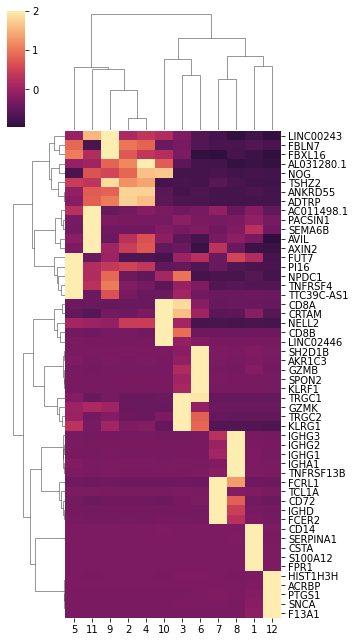

time: 1.36 s (started: 2021-09-06 20:49:59 +02:00)


In [30]:
ds.plot_marker_heatmap(
    group_key='RNA_cluster',
    topn=5,
    figsize=(5, 9)
)

The markers list for specific clusters can be obtained using `get_markers`. The numbers on the left index (in bold) are the gene/feature index as present in the feature attribute table (`ds.RNA.feats`). The table below is sorted (descending) by scores and this means that more specific markers are placed higher on the list.

In [31]:
ds.get_markers(
    group_key='RNA_cluster',
    group_id='1'
)

,score,names
6406,0.960718,CSTA
31743,0.956435,FPR1
9635,0.956269,CD14
23557,0.954499,SERPINA1
1925,0.954076,S100A12
...,...,...
3561,0.250333,CDC42EP3
8945,0.250249,GAPT
28139,0.250248,SLC16A6
22482,0.250170,RAB20


time: 32 ms (started: 2021-09-06 20:50:00 +02:00)


We can directly visualize the expression values for a gene of interest. It is usually a good idea to visually confirm the gene expression pattern across the cells at least this way.

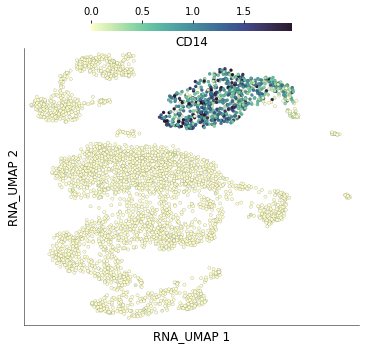

time: 578 ms (started: 2021-09-06 20:50:00 +02:00)


In [ ]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='CD14')

---
That is all for this vignette.

In [4]:
import matplotlib.pyplot as plt

time: 2.41 s (started: 2022-10-19 15:57:28 +02:00)


In [5]:
x = ds.cells.fetch("RNA_UMAP1")
y = ds.cells.fetch("RNA_UMAP2")

time: 16 ms (started: 2022-10-19 15:58:02 +02:00)


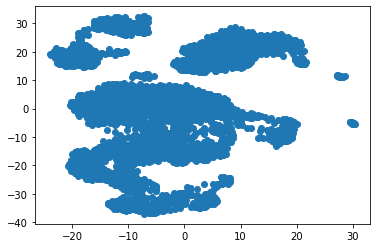

time: 360 ms (started: 2022-10-19 15:58:07 +02:00)


In [6]:
plt.scatter(x, y)

In [30]:
v = ds.get_cell_vals(from_assay='RNA', cell_key='I', k='RNA_leiden_cluster', use_precached=False, clip_fraction=0.05)

time: 16 ms (started: 2022-10-19 16:02:27 +02:00)


In [31]:
v

array([2, 2, 7, ..., 3, 6, 3])

time: 0 ns (started: 2022-10-19 16:02:28 +02:00)


In [32]:
len(v)

3940

time: 0 ns (started: 2022-10-19 16:02:30 +02:00)


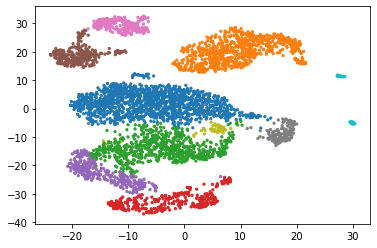

time: 328 ms (started: 2022-10-19 16:02:34 +02:00)


In [34]:
plt.scatter(x, y, c=v, cmap='tab10', s=5)

time: 484 ms (started: 2022-10-19 16:03:55 +02:00)


In [48]:
ds.RNA.save_normed_for_query(feat_key='I', batch_size=100)

Saving features:   0%|                                                                                        …

time: 1min 30s (started: 2022-10-19 16:06:15 +02:00)


In [59]:
nx = ds.get_imputed(feature_name='AQP3')
ny = ds.get_imputed(feature_name='NSG1')
nv = ds.get_imputed(feature_name='GAPDH')

INFO: Using existing MAGIC diffusion operator
INFO: Using existing MAGIC diffusion operator
INFO: Using existing MAGIC diffusion operator
time: 547 ms (started: 2022-10-19 16:12:59 +02:00)


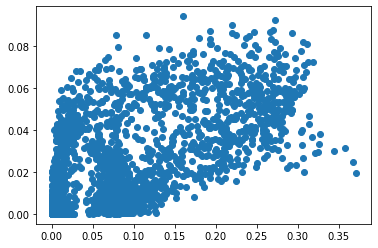

time: 281 ms (started: 2022-10-19 16:08:50 +02:00)


In [52]:
plt.scatter(nx, ny)

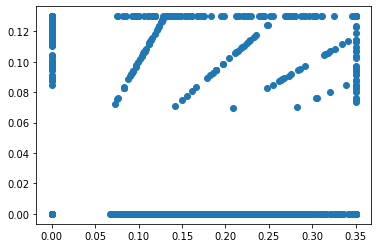

time: 343 ms (started: 2022-10-19 16:36:22 +02:00)


In [67]:
nx = ds.get_cell_vals(from_assay='RNA', cell_key='I', k='AQP3', use_precached=False, clip_fraction=0.05)
ny = ds.get_cell_vals(from_assay='RNA', cell_key='I', k='NSG1', use_precached=False, clip_fraction=0.05)
plt.scatter(nx, ny)

INFO: Using existing MAGIC diffusion operator


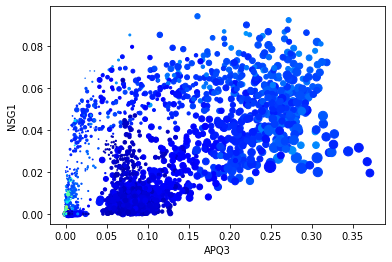

time: 609 ms (started: 2022-10-19 16:14:07 +02:00)


In [62]:
plt.scatter(nx, ny, c=nv, cmap='jet', s=ds.get_imputed(feature_name='CRIP2')*1000, label="cluster")
plt.xlabel("APQ3")
plt.ylabel("NSG1")
plt.show()

In [64]:
from scipy.stats import pearsonr

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


time: 3.88 s (started: 2022-10-19 16:23:27 +02:00)


In [66]:
pearsonr(nx, nv)

(-0.252304479475287, 2.8555695851965565e-58)

time: 15 ms (started: 2022-10-19 16:24:16 +02:00)


In [ ]:
-1 -> 0 -> 1